In [2]:
import joblib
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from RF_Model_Functions import *
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus
from scipy.signal import savgol_filter
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

C:\Users\smgls\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [3]:
spectra_train = joblib.load('cache/r20200406_234541_50.0sc_50.0sp_1_CPU/spectral/y_new_train.joblib')
spectra_test = joblib.load('cache/r20200406_234541_50.0sc_50.0sp_1_CPU/spectral/y_test.joblib')
labels_train = joblib.load('cache/r20200406_234541_50.0sc_50.0sp_1_CPU/spectral/x_new_train.joblib').reset_index()
labels_test = joblib.load('cache/r20200406_234541_50.0sc_50.0sp_1_CPU/spectral/x_test.joblib').reset_index()
labels_train_smaller = joblib.load('cache/r20200406_234541_50.0sc_50.0sp_1_CPU/spectral/x_train.joblib').reset_index()
spectra_train_smaller = joblib.load('cache/r20200406_234541_50.0sc_50.0sp_1_CPU/spectral/y_train.joblib')

In [6]:
from_one_hot_dict = {(1.,0.,0.,0.) : 0, (0.,1.,0.,0.) : 1, (0.,0.,1.,0.) : 2, (0.,0.,0.,1.) : 3}
from_one_hot_dict_materials = {(1.,0.,0.) : 0, (0.,1.,0.) : 1, (0.,0.,1.) : 2}

Train materials classification model

In [10]:
labels_train_material = labels_train.drop(columns = ['log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 'Geometry_TriangPrismIsosc',
                                                    'Geometry_parallelepiped', 'Geometry_sphere', 'Geometry_wire', 'index'] )
labels_test_material = labels_test.drop(columns = ['log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 'Geometry_TriangPrismIsosc',
                                                    'Geometry_parallelepiped', 'Geometry_sphere', 'Geometry_wire', 'index'] )

labels_train_material_as_array = labels_train_material.to_numpy()
labels_test_material_as_array = labels_test_material.to_numpy()

labels_train_material_as_array_wo_OHE = convert_from_one_hot(labels_train_material_as_array, from_one_hot_dict_materials)
labels_test_material_as_array_wo_OHE = convert_from_one_hot(labels_test_material_as_array, from_one_hot_dict_materials)


rf_model_materials = RandomForestClassifier(n_estimators=50, n_jobs = -1)
rf_model_materials.fit(spectra_train, labels_train_material_as_array_wo_OHE)
rf_model_materials.score(spectra_test, labels_test_material_as_array_wo_OHE)

1.0

Shape classification RF models multiclass prediction task - trains 4 models, on each of the 3 materials and on all 3 materials

In [4]:
labels_train_shape = labels_train.drop(columns = ['index','log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 
                                                'Material_Au', 'Material_SiN', 'Material_SiO2', 
                                                'index'])

In [5]:
rf_Au = Train_Random_Forests_Shape_Classification("Au", spectra_train, labels_train, spectra_test, labels_test,from_one_hot_dict, trees = 50)
rf_SiN = Train_Random_Forests_Shape_Classification("SiN", spectra_train, labels_train, spectra_test, labels_test,from_one_hot_dict, trees = 50)
rf_SiO2 = Train_Random_Forests_Shape_Classification("SiO2", spectra_train, labels_train, spectra_test, labels_test,from_one_hot_dict, trees = 50)
rf_all = Train_Random_Forests_Shape_Classification("All", spectra_train, labels_train, spectra_test, labels_test,from_one_hot_dict, trees = 50)

training Au
training SiN
training SiO2
training shape classifier all materials


Save the four shape classification models

In [6]:
joblib.dump([["RF Model SiO2", rf_SiO2], ["RF Model SiN",rf_SiN], ["RF Model Au", rf_Au], ["RF all materials", rf_all]], 
           "RF_Models_Shape_Classification.joblib")

['RF_Models_Shape_Classification.joblib']

Train and save binary shape classification models 

Confusion matrix, without normalization
[[1. 0.]
 [0. 1.]]


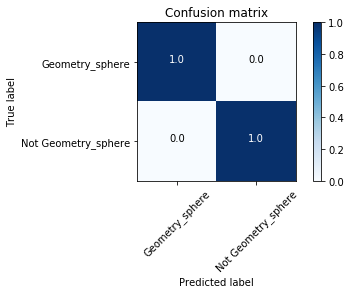

Confusion matrix, without normalization
[[0.76 0.24]
 [0.14 0.86]]


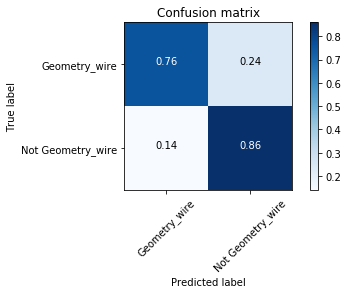

Confusion matrix, without normalization
[[0.83 0.17]
 [0.19 0.81]]


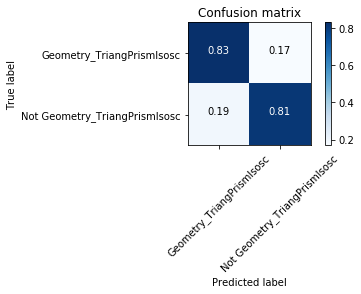

Confusion matrix, without normalization
[[0.72 0.28]
 [0.24 0.76]]


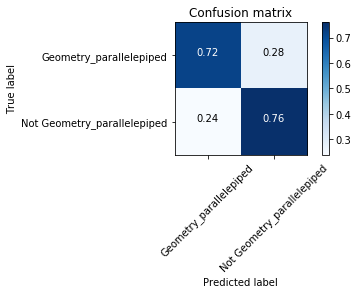

<Figure size 432x288 with 0 Axes>

In [5]:
shape_classificaion_shapes = ['Geometry_sphere', 'Geometry_wire', 'Geometry_TriangPrismIsosc', 'Geometry_parallelepiped']
for shape in shape_classificaion_shapes:
    rf_binary_model = binary_classification_models(labels_train, spectra_train, labels_test, spectra_test, shape,
                                 confusion_matrix_=True)
    joblib.dump(rf_binary_model, "RF Binary Classification " + shape + ".joblib" )

Train and save random forest size regression model. This model predicts all four size parameters from spectra. This is a sklearn random forest multioutput regressor, which trains all four models in parallel and then just sticks all of their outputs together. Therefore, accuracy of each model can be found by just training a model to predict one parameter and examining its accuracy. 

In [8]:
rf_size_regression = Train_Random_Forests_Size_Regression("all", spectra_train, labels_train, spectra_test, labels_test, 50)

In [9]:
print(rf_size_regression)
joblib.dump(rf_size_regression, "RF Size Regression.joblib")

(0.9061593718281074, MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=50,
                          

['RF Size Regression.joblib']

Train and save random forest size regression models on each of the four size parameters. 

In [10]:
rf_size_regression_area_vol = Train_Random_Forests_Size_Regression("volume", spectra_train, labels_train, spectra_test, labels_test, 50)
joblib.dump(rf_size_regression_area_vol, "RF Size Regression Area over Volume.joblib")

['RF Size Regression Area over Volume.joblib']

In [11]:
rf_size_regression_short_dim = Train_Random_Forests_Size_Regression("short_dim", spectra_train, labels_train, spectra_test, labels_test, 50)
joblib.dump(rf_size_regression_short_dim, "RF Size Regression shortest dim.joblib")

['RF Size Regression shortest dim.joblib']

In [12]:
rf_size_regression_middle_dim = Train_Random_Forests_Size_Regression("middle_dim", spectra_train, labels_train, spectra_test, labels_test, 50)
joblib.dump(rf_size_regression_middle_dim, "RF Size Regression middle dim.joblib")

['RF Size Regression middle dim.joblib']

In [13]:
rf_size_regression_long_dim = Train_Random_Forests_Size_Regression("long_dim", spectra_train, labels_train, spectra_test, labels_test, 50)
joblib.dump(rf_size_regression_long_dim, "RF Size Regression long dim.joblib")

['RF Size Regression long dim.joblib']

Test size regression model on test sets containing one specific material

In [14]:
labels_test_material = labels_test.drop(columns = ['index','log Area/Vol', 'ShortestDim', 'MiddleDim', 'LongDim', 
                                                'Geometry_sphere', 'Geometry_wire', 'Geometry_TriangPrismIsosc', 
                                                'Geometry_parallelepiped', 'index'])
indicies_to_drop_test_list_SiO2 = drop_indicies(labels_test_material, 'Material_SiO2', 0, False)
indicies_to_drop_test_list_SiN = drop_indicies(labels_test_material, 'Material_SiN', 0, False)
indicies_to_drop_test_list_Au = drop_indicies(labels_test_material, 'Material_Au', 0, False)

In [15]:
labels_test_size = labels_test.drop(columns = ['index', 'Geometry_sphere', 'Geometry_wire', 'Geometry_TriangPrismIsosc', 
                                            'Geometry_parallelepiped', 'index', 'Material_Au', 'Material_SiN', 'Material_SiO2'])
spectra_test_df = pd.DataFrame(spectra_test)
spectra_test_SiO2 = np.asarray(spectra_test_df.drop(indicies_to_drop_test_list_SiO2[1]))
spectra_test_SiN = np.asarray(spectra_test_df.drop(indicies_to_drop_test_list_SiN[1]))
spectra_test_Au = np.asarray(spectra_test_df.drop(indicies_to_drop_test_list_Au[1]))

In [16]:
labels_test_size_SiO2 = labels_test_size.drop(indicies_to_drop_test_list_SiO2[1])
labels_test_size_SiN = labels_test_size.drop(indicies_to_drop_test_list_SiN[1])
labels_test_size_Au = labels_test_size.drop(indicies_to_drop_test_list_Au[1])

accuracy_size_regression_SiO2 = rf_size_regression[1].score(spectra_test_SiO2, labels_test_size_SiO2)
accuracy_size_regression_SiN =rf_size_regression[1].score(spectra_test_SiN, labels_test_size_SiN)
accuracy_size_regression_Au =rf_size_regression[1].score(spectra_test_Au, labels_test_size_Au)

In [23]:
print(accuracy_size_regression_SiO2)
print(accuracy_size_regression_SiN)
print(accuracy_size_regression_Au)

0.9166090980972443
0.9109951393561627
0.8949743685817872


['size_regression_material_accuracy.joblib']

In [18]:
accuracies_size_regression_material = [["accuracy_size_regression_SiO2", accuracy_size_regression_SiO2],
                                      ["accuracy_size_regression_SiN", accuracy_size_regression_SiN],
                                      ["accuracy_size_regression_Au", accuracy_size_regression_Au]]
joblib.dump(accuracies_size_regression_material, "accuracies_size_regression_material.joblib")

['accuracies_size_regression_material.joblib']

Test size regression model on test sets containing one specific material

In [19]:
indicies_to_drop_test_list_Parallelepiped = drop_indicies(labels_test, 'Geometry_parallelepiped', 0, False)
indicies_to_drop_test_list_Sphere = drop_indicies(labels_test, 'Geometry_sphere', 0, False)
indicies_to_drop_test_list_Triangle = drop_indicies(labels_test, 'Geometry_TriangPrismIsosc', 0, False)
indicies_to_drop_test_list_Wire = drop_indicies(labels_test, 'Geometry_wire', 0, False)

labels_test_size_Parallelepiped = labels_test_size.drop(indicies_to_drop_test_list_Parallelepiped[1])
labels_test_size_Sphere = labels_test_size.drop(indicies_to_drop_test_list_Sphere[1])
labels_test_size_Triangle = labels_test_size.drop(indicies_to_drop_test_list_Triangle[1])
labels_test_size_Wire = labels_test_size.drop(indicies_to_drop_test_list_Wire[1])

spectra_test_Parallelepiped = spectra_test_df.drop(indicies_to_drop_test_list_Parallelepiped[1])
spectra_test_Sphere = spectra_test_df.drop(indicies_to_drop_test_list_Sphere[1])
spectra_test_Triangle = spectra_test_df.drop(indicies_to_drop_test_list_Triangle[1])
spectra_test_Wire = spectra_test_df.drop(indicies_to_drop_test_list_Wire[1])


In [20]:
accuracy_size_regression_Parallelepiped = rf_size_regression[1].score(spectra_test_Parallelepiped, labels_test_size_Parallelepiped)
accuracy_size_regression_Sphere = rf_size_regression[1].score(spectra_test_Sphere, labels_test_size_Sphere)
accuracy_size_regression_Triangle = rf_size_regression[1].score(spectra_test_Triangle, labels_test_size_Triangle)
accuracy_size_regression_Wire = rf_size_regression[1].score(spectra_test_Wire, labels_test_size_Wire)


In [21]:
print(accuracy_size_regression_Parallelepiped)
print(accuracy_size_regression_Sphere)
print(accuracy_size_regression_Triangle)
print(accuracy_size_regression_Wire)

0.8488878643683283
0.9982870861542521
0.9058667385442793
0.8848896306944871


In [22]:
accuracies_size_regression_shape = [["accuracy_size_regression_parallelepiped", accuracy_size_regression_Parallelepiped],
                                      ["accuracy_size_regression_sphere", accuracy_size_regression_Sphere],
                                      ["accuracy_size_regression_triangle", accuracy_size_regression_Triangle],
                                      ["accuracy_size_regression_wire", accuracy_size_regression_Wire]]
joblib.dump(accuracies_size_regression_shape, "accuracies_size_regression_shape.joblib")

['accuracies_size_regression_shape.joblib']